In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config IPCompleter.greedy = True

In [2]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
ads_data = pd.read_csv('ads_data.csv')

In [4]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


1. Разберемся с распределением количества показов и кликов. Посчитаем среднее количество показов и среднее количество кликов на объявления за весь период(Округлим до целых)

In [5]:
# Посчитаем кол-во кликов и просмотров

number_per_ad_per_event = ads_data \
                            .groupby(['ad_id', 'event'], as_index=False) \
                            .agg({'time': 'count'}) \
                            .rename(columns={'time': 'event_number'})
number_per_ad_per_event.head()

,ad_id,event,event_number
0,2,click,1
1,2,view,101
2,3,click,3
3,3,view,184
4,1902,click,1


In [6]:
# Переведем таблицу в более удобный вид для дальнейшего подсчета средних

click_view = number_per_ad_per_event.pivot(index='ad_id', 
                                           columns='event', 
                                           values='event_number') \
                                    .fillna(0)
click_view.head()

event,click,view
ad_id,,
2,1.0,101.0
3,3.0,184.0
1902,1.0,41.0
2064,0.0,35.0
2132,1.0,58.0


In [7]:
# Считаем среднее

click_view.mean() \
          .round()

event
click    113.0
view     923.0
dtype: float64

In [8]:
# Другой метод

number_per_ad_per_event \
                         .groupby('event') \
                         .agg({'event_number': 'sum'}) \
                         .div(ads_data.ad_id.nunique()) \
                         .round()

,event_number
event,
click,113.0
view,923.0


2. Нарисуем график распределения показов на объявление за весь период.

In [9]:
# Выберем из ДатаФрейма только информацию о показах

views_per_ad = number_per_ad_per_event \
                                        .query('event == "view"')

In [10]:
views_per_ad.event_number.describe()

count       956.000000
mean        931.822176
std       13006.492754
min          10.000000
25%          36.000000
50%          84.000000
75%         209.250000
max      351802.000000
Name: event_number, dtype: float64

In [11]:
# Воспользуемся логарифмированием, чтобы избавиться от выбросов и создадим колонку с этими значениями

views_per_ad['log_views'] = np.log(views_per_ad.event_number)

/home/zlong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


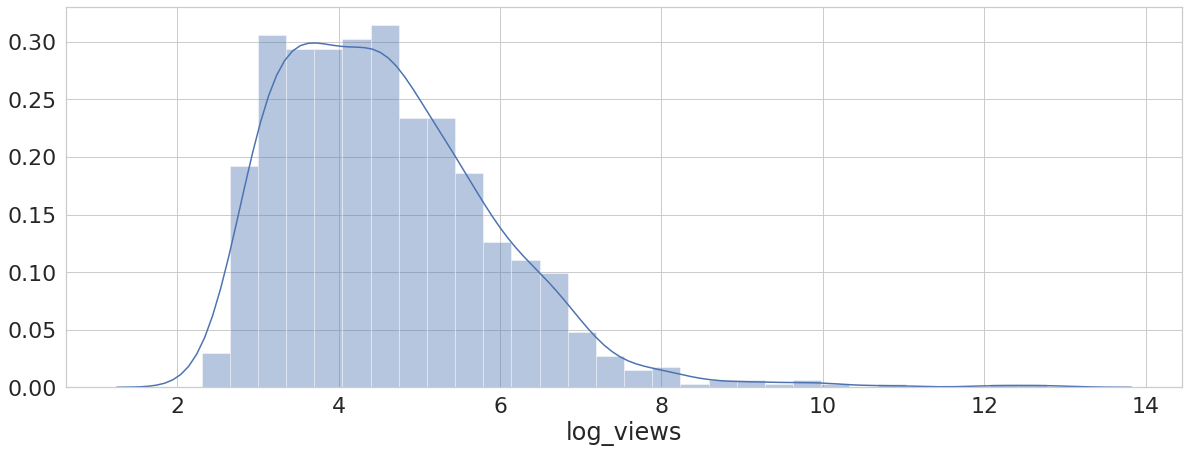

In [12]:
sns.distplot(views_per_ad.log_views)

3. А теперь посчитаем скользящее среднее показов с окном.

In [13]:
# Разобьем показы рекламных компаний по числам

ads_view_per_date = ads_data.query('event =="view"') \
                            .pivot_table(index='ad_id',
                                         columns='date',
                                         values='time',
                                         aggfunc='count')

In [14]:
ads_view_per_date

date,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06
ad_id,,,,,,
2,83.0,18.0,NaN,NaN,NaN,NaN
3,158.0,26.0,NaN,NaN,NaN,NaN
1902,NaN,NaN,34.0,7.0,NaN,NaN
2064,NaN,28.0,7.0,NaN,NaN,NaN
2132,NaN,NaN,25.0,27.0,6.0,NaN
...,...,...,...,...,...,...
122004,85.0,15.0,NaN,NaN,NaN,NaN
122013,NaN,NaN,NaN,134.0,22.0,NaN
122023,NaN,NaN,NaN,53.0,15.0,NaN


In [15]:
# Посчитаем средне число показов по дате

maen_views = ads_view_per_date.mean()
maen_views

date
2019-04-01    154.482270
2019-04-02    137.786982
2019-04-03    163.952778
2019-04-04    675.901720
2019-04-05    919.109677
2019-04-06    277.122727
dtype: float64

In [16]:
# Считаем скользящее средне с окном в 2 эллемента

rolling_views = maen_views.rolling(2).mean()
rolling_views

date
2019-04-01           NaN
2019-04-02    146.134626
2019-04-03    150.869880
2019-04-04    419.927249
2019-04-05    797.505699
2019-04-06    598.116202
dtype: float64

4. Теперь попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов.

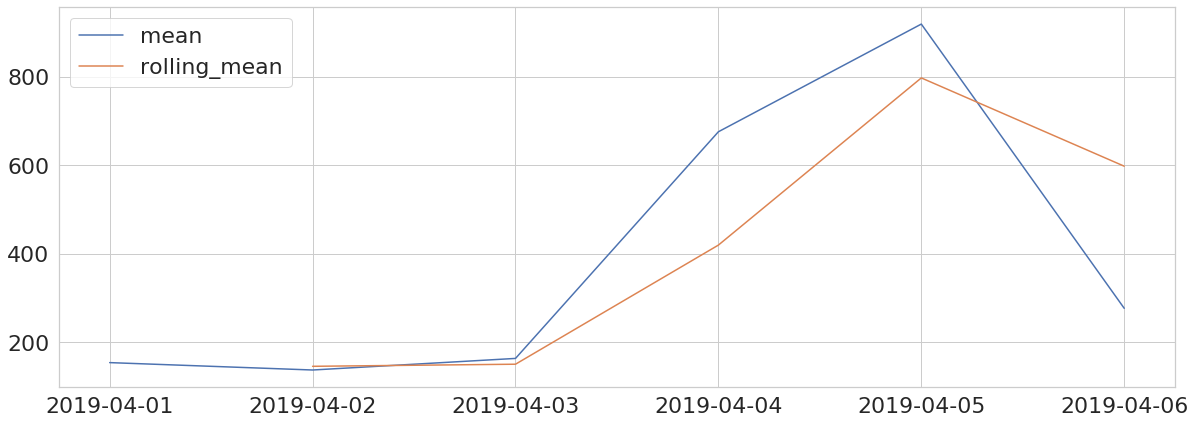

In [17]:
sns.lineplot(data=maen_views, label='mean')
sns.lineplot(data=rolling_views, label='rolling_mean')

In [18]:
# Посчитаем разницу между средними и возьмем модуль(чтобы убрать отрицательные значения)
# + возьмем индекс наибольшего значения(для изучения аномалии в этот день)

anomaly_day = maen_views.subtract(rolling_views) \
                        .abs() \
                        .idxmax()
anomaly_day

'2019-04-06'

5. Напишем функцию, которая найдет проблемное объявление (с наибольшим/наименишим количеством показов) в день, в который была замечена самая большая по модулю аномалия.

In [19]:
# Выведем разницу средних в этот(аномальный) день

difference_value = maen_views.subtract(rolling_views)[anomaly_day]
difference_value

-320.9934750733138

In [20]:
# Напишем условие для поиска id с аномально высоким или низким значением 

# Если разница меньше или равна 0
if difference_value <= 0:
    anomaly_ad = ads_view_per_date[anomaly_day].idxmax()
    
# Если разница больше 0
else:
    anomaly_ad = ads_view_per_date[anomaly_day].idxmin()
    

In [21]:
anomaly_ad

112583

In [22]:
# Напишем функцию для поиска id аномалии, чтобы в следующий раз запустить поиск 1й командой

def find_anomaly_id(path):
    ads_data = pd.read_csv(path)
    
    ads_view_per_date = ads_data.query('event =="view"') \
                            .pivot_table(index='ad_id',
                                         columns='date',
                                         values='time',
                                         aggfunc='count')
    
    maen_views = ads_view_per_date.mean()
    
    mean_difference = maen_views.subtract(rolling_views) # Для того что бы не считать несколько раз, занесем в переменную
    
    anomaly_day = mean_difference \
                                   .abs() \
                                   .idxmax()
    
    difference_value = maen_views.subtract(rolling_views)[anomaly_day]

    if difference_value <= 0:
        anomaly_ad = ads_view_per_date[anomaly_day].idxmax()
    
    else:
        anomaly_ad = ads_view_per_date[anomaly_day].idxmin()
    
    return anomaly_ad

In [23]:
# Проверим

find_anomaly_id('ads_data.csv')

112583